In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

# Suprimir todos os warnings
warnings.filterwarnings("ignore")

# 4 - Baseado nesses dados, faça um modelo que estime a probabilidade de uma pessoa morrer, uma vez que está contaminada com COVID, e considerando os inputs de **idade**, **gênero** e **doenças pré-existentes**.

Carregar o CSV original para desenvolvermos o melhor modelo de predição.

In [2]:
def ler_csv(path=None):
    # Caso não informado o path, usar o caminho padrão da máquina.
    if path is None:
        path = "D:\\Python\\finance\\Absolute\\Dados\\20240120_Casos_e_obitos_ESP\\tmp\\tmpi0lf4neq\\20240120_Casos_e_obitos_ESP.csv"

    # Usando a estrutura try e except para ler o arquivo.
    try:
        df = pd.read_csv(path,
                         sep = ';', # Separador usando ';' como parâmetro
                         header=0)  # Define-se a linha 0 como index.
        return df

    except Exception as e:
        print(f"Ocorreu um erro ao ler o arquivo: {e}")
        return None

In [3]:
path = "//content//drive//MyDrive//Absolute//20240120_Casos_e_obitos_ESP.csv"

In [4]:
exercicio_4 = ler_csv(path= path)

In [5]:
exercicio_4.head()

,Asma,Cardiopatia,Data_Inicio_Sintomas,Diabetes,Diagnostico_Covid19,Doenca_Hematologica,Doenca_Hepatica,Doenca_Neurologica,Doenca Renal,Genero,Idade,Imunodepressao,Municipio,Obesidade,Obito,Outros_Fatores_De_Risco,Pneumopatia,Puérpera,Síndrome_De_Down
0,IGNORADO,IGNORADO,15/07/2022,IGNORADO,CONFIRMADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,MASCULINO,69.0,IGNORADO,ASSIS,IGNORADO,0,IGNORADO,IGNORADO,IGNORADO,IGNORADO
1,IGNORADO,IGNORADO,21/02/2021,IGNORADO,CONFIRMADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,FEMININO,60.0,IGNORADO,SÃO PAULO,IGNORADO,0,IGNORADO,IGNORADO,IGNORADO,IGNORADO
2,IGNORADO,IGNORADO,23/06/2021,IGNORADO,CONFIRMADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,MASCULINO,58.0,IGNORADO,ARARAQUARA,IGNORADO,0,IGNORADO,IGNORADO,IGNORADO,IGNORADO
3,IGNORADO,IGNORADO,03/02/2021,IGNORADO,CONFIRMADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,FEMININO,45.0,IGNORADO,SÃO PAULO,IGNORADO,0,IGNORADO,IGNORADO,IGNORADO,IGNORADO
4,IGNORADO,IGNORADO,23/02/2021,IGNORADO,CONFIRMADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,FEMININO,42.0,IGNORADO,SÃO PAULO,IGNORADO,0,IGNORADO,IGNORADO,IGNORADO,IGNORADO


In [6]:
exercicio_4.shape

(6770928, 19)

In [7]:
exercicio_4.isna().sum()

Asma                            0
Cardiopatia                     0
Data_Inicio_Sintomas       244724
Diabetes                        0
Diagnostico_Covid19             0
Doenca_Hematologica             0
Doenca_Hepatica                 0
Doenca_Neurologica              0
Doenca Renal                    0
Genero                          1
Idade                      221457
Imunodepressao                  0
Municipio                       0
Obesidade                       0
Obito                           0
Outros_Fatores_De_Risco         0
Pneumopatia                     0
Puérpera                        0
Síndrome_De_Down                0
dtype: int64

In [31]:
# Resumo estatístico da coluna 'Idade'
resumo_estatistico = exercicio_4['Idade'].value_counts().sort_index()

# Salvando o resumo estatístico em um arquivo de texto
with open('/content/drive/MyDrive/Absolute/resumo_estatistico_idade.txt', 'w') as f:
    f.write(resumo_estatistico.to_string())

In [33]:
print(exercicio_4['Idade'].max())
print(exercicio_4['Idade'].min())

2188.0
0.0


## 4.1 - Tratamento da Coluna "Idade" e "Genero" removendo as linhas NaN e outliers.

In [34]:
def tratamento_coluna_idade_genero(df_dados):

    # Realizar o tratamento de excluir as linhas que são vazias na coluna 'Idade'
    try:
        # Verificar se a coluna 'Idade' existe no DataFrame
        if 'Idade' not in df_dados.columns or 'Genero' not in df_dados.columns:
            raise KeyError("A coluna 'Idade' e/ou 'Genero' não existe no DataFrame.")

        # Excluir linhas com NaN nas colunas 'Idade' e 'Genero'
        df_dados = df_dados.dropna(subset=['Idade', 'Genero']).reset_index(drop=True)

        # Excluir linhas onde o valor na coluna 'Idade' é maior que 150
        df_dados = df_dados[df_dados['Idade'] <= 150].reset_index(drop=True)

    except KeyError as e:
        print(f"Erro de chave: {e}")
    except Exception as e:
        print(f"Ocorreu um erro ao realizar o tratamento dos dados: {e}")

    return df_dados

In [35]:
novo_exercicio_4 = tratamento_coluna_idade_genero(df_dados= exercicio_4)

In [36]:
novo_exercicio_4.isna().sum()

Asma                           0
Cardiopatia                    0
Data_Inicio_Sintomas       30310
Diabetes                       0
Diagnostico_Covid19            0
Doenca_Hematologica            0
Doenca_Hepatica                0
Doenca_Neurologica             0
Doenca Renal                   0
Genero                         0
Idade                          0
Imunodepressao                 0
Municipio                      0
Obesidade                      0
Obito                          0
Outros_Fatores_De_Risco        0
Pneumopatia                    0
Puérpera                       0
Síndrome_De_Down               0
dtype: int64

In [37]:
novo_exercicio_4.shape

(6549469, 19)

In [38]:
novo_exercicio_4.columns

Index(['Asma', 'Cardiopatia', 'Data_Inicio_Sintomas', 'Diabetes',
       'Diagnostico_Covid19', 'Doenca_Hematologica', 'Doenca_Hepatica',
       'Doenca_Neurologica', 'Doenca Renal', 'Genero', 'Idade',
       'Imunodepressao', 'Municipio', 'Obesidade', 'Obito',
       'Outros_Fatores_De_Risco', 'Pneumopatia', 'Puérpera',
       'Síndrome_De_Down'],
      dtype='object')

## 4.2 - Tratamento das Colunas Normalizando os dados.

Irei normalizar os dados tanto referentes às colunas "Genero", "Idade" e as doenças pré-existentes.
<p>Além disso, irei excluir as colunas a não serem usadas para facilitar o manejo dos dados.

Normalizção a ser usada nas doenças pré-existentes: **'IGNORADO': 0, 'NÃO': 0, 'SIM': 1**


In [39]:
novo_exercicio_4['Asma'].value_counts()

Asma
IGNORADO    6313091
NÃO          219964
SIM           16414
Name: count, dtype: int64

In [40]:
novo_exercicio_4['Genero'].value_counts()

Genero
FEMININO      3595411
MASCULINO     2951199
INDEFINIDO       2851
IGNORADO            8
Name: count, dtype: int64

In [41]:
novo_exercicio_4['Outros_Fatores_De_Risco'].value_counts()

Outros_Fatores_De_Risco
IGNORADO    6266700
SIM          154341
NÃO          128428
Name: count, dtype: int64

In [42]:
novo_exercicio_4['Idade'].describe()

count    6.549469e+06
mean     4.108880e+01
std      1.846766e+01
min      0.000000e+00
25%      2.800000e+01
50%      4.000000e+01
75%      5.400000e+01
max      1.360000e+02
Name: Idade, dtype: float64

In [43]:
print(novo_exercicio_4['Idade'].max())
print(novo_exercicio_4['Idade'].min())

136.0
0.0


Na coluna **"Genero"** usaremos o método **One-Hot Encoding** com o objetivo de manter as informações.

Na coluna **"Idade"** usaremos o método **MinMaxScaler** com o objetivo de normalizar as informações no intervalo entre 0 e 1.

In [44]:
def min_max_scaling(data):
    min_value = min(data)
    max_value = max(data)
    scaled_data = [(x - min_value) / (max_value - min_value) for x in data]
    return scaled_data

def tratamento_normalizacao(df_dados):
    try:
        df_dados = df_dados.copy()

        # Remover colunas irrelevantes
        df_dados = df_dados.drop(['Data_Inicio_Sintomas', 'Municipio', 'Diagnostico_Covid19'], axis=1)

        # Listar todas as colunas de doenças.
        colunas_doencas = [
            'Asma', 'Cardiopatia', 'Diabetes', 'Doenca_Hematologica', 'Doenca_Hepatica',
            'Doenca_Neurologica', 'Doenca Renal', 'Imunodepressao', 'Obesidade',
            'Pneumopatia', 'Puérpera', 'Síndrome_De_Down', 'Outros_Fatores_De_Risco'
        ]

        # Verificar se todas as colunas de doenças existem no DataFrame.
        for coluna in colunas_doencas:
            if coluna not in df_dados.columns:
                raise KeyError(f"A coluna '{coluna}' não existe no DataFrame.")

        # Tratar valores "IGNORADO", "NÃO" e "SIM" nas colunas de doenças.
        for coluna in colunas_doencas:
            df_dados[coluna] = df_dados[coluna].astype(str)
            df_dados[coluna] = df_dados[coluna].str.strip().str.upper()
            df_dados[coluna] = df_dados[coluna].replace({'IGNORADO': 0, 'NÃO': 0, 'SIM': 1})

        # Normalizar os valores na coluna 'Genero'.
        df_dados['Genero'] = df_dados['Genero'].astype(str)
        df_dados['Genero'] = df_dados['Genero'].str.strip().str.upper()

        # Certificar que valores de 'Genero' sejam strings categóricas
        df_dados['Genero'] = df_dados['Genero'].astype('category')

        # Aplicar one-hot encoding.
        df_dados = pd.get_dummies(df_dados, columns=['Genero'], prefix='Genero', dtype=int)

        # Tratar idades.
        idade_data = df_dados['Idade'].values.tolist()
        df_dados['Idade'] = min_max_scaling(idade_data)

        return df_dados

    except KeyError as e:
        print(f"Erro de chave: {e}")
        return None

    except Exception as e:
        print(f"Ocorreu um erro no tratamento de normalização: {e}")
        return None

In [45]:
dados_tratados_4 = tratamento_normalizacao(df_dados=novo_exercicio_4)

In [46]:
dados_tratados_4.head()

,Asma,Cardiopatia,Diabetes,Doenca_Hematologica,Doenca_Hepatica,Doenca_Neurologica,Doenca Renal,Idade,Imunodepressao,Obesidade,Obito,Outros_Fatores_De_Risco,Pneumopatia,Puérpera,Síndrome_De_Down,Genero_FEMININO,Genero_IGNORADO,Genero_INDEFINIDO,Genero_MASCULINO
0,0,0,0,0,0,0,0,0.507353,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0.441176,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0.426471,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0.330882,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0.308824,0,0,0,0,0,0,0,1,0,0,0


In [47]:
dados_tratados_4.columns

Index(['Asma', 'Cardiopatia', 'Diabetes', 'Doenca_Hematologica',
       'Doenca_Hepatica', 'Doenca_Neurologica', 'Doenca Renal', 'Idade',
       'Imunodepressao', 'Obesidade', 'Obito', 'Outros_Fatores_De_Risco',
       'Pneumopatia', 'Puérpera', 'Síndrome_De_Down', 'Genero_FEMININO',
       'Genero_IGNORADO', 'Genero_INDEFINIDO', 'Genero_MASCULINO'],
      dtype='object')

In [48]:
dados_tratados_4.shape

(6549469, 19)

In [49]:
dados_tratados_4['Genero_FEMININO'].value_counts()

Genero_FEMININO
1    3595411
0    2954058
Name: count, dtype: int64

## 4.3 - Separação dos dados para treinamento do Modelo Preditivo.

In [50]:
def separacao_treino(df_dados):
    try:
        # Separar as features (X) e o target (y)
        X = df_dados.drop(columns=['Obito'])
        y = df_dados['Obito']

        # Dividir o dataset em conjuntos de treinamento e teste
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        return X_train, X_test, y_train, y_test

    except KeyError as e:
        print(f"Erro de chave: {e}")
        return None, None, None, None
    except Exception as e:
        print(f"Ocorreu um erro ao separar os dados de treinamento e teste: {e}")
        return None, None, None, None

In [51]:
x_train, x_test, y_train, y_test = separacao_treino(df_dados=dados_tratados_4)

In [52]:
x_train.head()

,Asma,Cardiopatia,Diabetes,Doenca_Hematologica,Doenca_Hepatica,Doenca_Neurologica,Doenca Renal,Idade,Imunodepressao,Obesidade,Outros_Fatores_De_Risco,Pneumopatia,Puérpera,Síndrome_De_Down,Genero_FEMININO,Genero_IGNORADO,Genero_INDEFINIDO,Genero_MASCULINO
987649,0,0,0,0,0,0,0,0.419118,0,0,0,0,0,0,0,0,0,1
1242156,0,0,0,0,0,0,0,0.323529,0,0,0,0,0,0,0,0,0,1
5595424,0,1,0,0,0,0,0,0.389706,0,0,0,0,0,0,1,0,0,0
1278441,0,0,0,0,0,0,0,0.279412,0,0,0,0,0,0,1,0,0,0
2791121,0,0,0,0,0,0,0,0.250000,0,0,0,0,0,0,0,0,0,1


In [ ]:
x_train.iloc[0]

Asma                       0.000000
Cardiopatia                1.000000
Diabetes                   1.000000
Doenca_Hematologica        0.000000
Doenca_Hepatica            0.000000
Doenca_Neurologica         1.000000
Doenca Renal               0.000000
Idade                      0.026051
Imunodepressao             0.000000
Obesidade                  0.000000
Outros_Fatores_De_Risco    1.000000
Pneumopatia                0.000000
Puérpera                   0.000000
Síndrome_De_Down           0.000000
Genero_FEMININO            0.000000
Genero_IGNORADO            0.000000
Genero_INDEFINIDO          0.000000
Genero_MASCULINO           1.000000
Name: 987649, dtype: float64

## 4.4 - Modelo Preditivo

Existe diversos modelos preditivos possíveis, testaremos os mais simples a seguir:

*   Regressão Logística
*   Random Forest



### Regressão Logística

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import joblib

# Criar o modelo de regressão logística
logistic_regression = LogisticRegression(random_state=0)

# Treinar o modelo com os dados de treinamento
logistic_regression.fit(x_train, y_train)

# Fazer previsões com os dados de teste
y_pred = logistic_regression.predict(x_test)

# Avaliar o modelo
print("Regressão Logística")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Regressão Logística
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1910316
           1       0.49      0.16      0.25     54525

    accuracy                           0.97   1964841
   macro avg       0.73      0.58      0.62   1964841
weighted avg       0.96      0.97      0.97   1964841

Accuracy: 0.9720944341043372


In [54]:
# Salvar o modelo no arquivo
joblib.dump(logistic_regression, '//content//drive//MyDrive//Absolute//modelo_regressao_logistica.joblib')
print("Modelo salvo como 'modelo_regressao_logistica.joblib'")

Modelo salvo como 'modelo_regressao_logistica.joblib'


### Random Forest

*   https://crunchingthedata.com/max-depth-in-random-forests/
*   https://crunchingthedata.com/random-forest-overfitting/



In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

# Treinamento do modelo
rf = RandomForestClassifier(n_estimators=75, min_samples_split=5, min_samples_leaf=10)
rf.fit(x_train, y_train)

# Previsão
y_pred = rf.predict(x_test)

# Avaliação do modelo
print("Random Forest")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Salvamento do modelo treinado
joblib.dump(rf, '//content//drive//MyDrive//Absolute//random_forest_model.joblib')
print("Modelo salvo como 'random_forest_model.joblib'")

Random Forest
              precision    recall  f1-score   support

           0       0.97      1.00      0.99   1910316
           1       0.56      0.07      0.12     54525

    accuracy                           0.97   1964841
   macro avg       0.77      0.53      0.55   1964841
weighted avg       0.96      0.97      0.96   1964841

Accuracy: 0.9726573295243738
Modelo salvo como 'random_forest_model.joblib'


In [56]:
# Carregar o modelo salvo
rf_loaded = joblib.load('//content//drive//MyDrive//Absolute//random_forest_model_50_split_5_10_leaf_ue.joblib')

# Usar o modelo carregado para fazer previsões
y_pred_loaded = rf_loaded.predict(x_test)

# Avaliação do modelo carregado (opcional, apenas para verificar)
print("Random Forest (Modelo Carregado)")
print(classification_report(y_test, y_pred_loaded))
print("Accuracy:", accuracy_score(y_test, y_pred_loaded))

Random Forest (Modelo Carregado)
              precision    recall  f1-score   support

           0       0.97      1.00      0.99   1910316
           1       0.56      0.07      0.12     54525

    accuracy                           0.97   1964841
   macro avg       0.77      0.53      0.55   1964841
weighted avg       0.96      0.97      0.96   1964841

Accuracy: 0.9726573295243738


### Iremos seguir com o modelo Random Forest

As configurações do modelo de treinamento foram: *  

*   **RandomForestClassifier(n_estimators=50, min_samples_split=5, min_samples_leaf=10)**




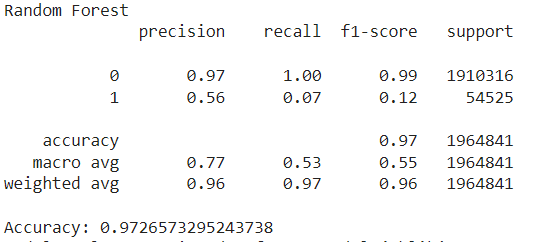

In [57]:
def modelo_preditivo(modelo_path, x_test):
    """
    Carrega um modelo salvo e usa-o para prever as probabilidades de óbito e sobrevivência.

    Parâmetros:
    modelo_path (str): Caminho para o arquivo do modelo salvo.
    x_test (pd.DataFrame ou np.ndarray): Conjunto de dados de teste.

    Retorna:
    np.ndarray: Matriz de probabilidades previstas, onde cada linha representa uma amostra
                e cada coluna representa a probabilidade da amostra pertencer a uma classe específica.
    """
    try:
        # Definir o caminho padrão do modelo, se não fornecido
        if modelo_path is None:
            modelo_path = '//content//drive//MyDrive//Absolute//random_forest_model_50_split_5_leaf_10_ue.joblib'

        # Carregar o modelo salvo
        rf_loaded = joblib.load(modelo_path)

        # Usar o modelo carregado para prever as probabilidades
        y_prob = rf_loaded.predict_proba(x_test)

        # Retornar as probabilidades das duas classes
        return y_prob

    except Exception as e:
        print(f"Erro ao carregar o modelo e prever probabilidades: {e}")
        return None

In [58]:
def treinar_modelo(x_train, x_test, y_train, y_test, modelo_path):
    """
    Treina um modelo RandomForestClassifier, salva o modelo treinado e retorna as métricas de avaliação.

    Parâmetros:
    x_train : Conjunto de dados de treinamento.
    x_test : Conjunto de dados de teste.
    y_train : Labels de treinamento.
    y_test : Labels de teste.
    modelo_path : Caminho para salvar o modelo treinado.

    Retorna:
    rf : Modelo treinado.
    """
    try:
        # Treinamento do modelo
        rf = RandomForestClassifier(n_estimators=50, max_depth=5, min_samples_leaf=10)
        rf.fit(x_train, y_train)

        # Previsão
        y_pred = rf.predict(x_test)

        # Avaliação do modelo
        report = classification_report(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        print("Random Forest")
        print(report)
        print("Accuracy:", accuracy)

        # Salvamento do modelo treinado
        joblib.dump(rf, modelo_path)
        print(f"Modelo salvo como '{modelo_path}'")

        # Retornar o modelo treinado
        return rf

    except Exception as e:
        print(f"Erro no treinamento e salvamento do modelo: {e}")
        return None


## 4.5 - Versão Final

In [60]:
path = "//content//drive//MyDrive//Absolute//20240120_Casos_e_obitos_ESP.csv"

# Carregar o CSV com os dados.
exercicio_4 = ler_csv(path= path)

# Tratamento da Coluna "Idade" e "Genero" removendo as linhas NaN.
novo_exercicio_4 = tratamento_coluna_idade_genero(df_dados= exercicio_4)

# Tratamento das Colunas Normalizando os dados.
dados_tratados_4 = tratamento_normalizacao(df_dados=novo_exercicio_4)

# Separação dos dados para treinamento do Modelo Preditivo.
x_train, x_test, y_train, y_test = separacao_treino(df_dados=dados_tratados_4)

# Modelo Preditivo : Random Forest

# Caso não tenha uma modelo treinado
modelo = treinar_modelo(x_train = x_train, x_test = x_test,
                        y_train = y_train, y_test = y_test,
                        modelo_path='//content//drive//MyDrive//Absolute//random_forest_model_test.joblib')

# Caso queira usar um modelo treinado e obter a predição usar a seguinte linha abaixo.
# modelo = modelo_preditivo(modelo_path = '//content//drive//MyDrive//Absolute//random_forest_model_test.joblib', x_test)

Random Forest
              precision    recall  f1-score   support

           0       0.97      1.00      0.99   1910316
           1       0.68      0.00      0.01     54525

    accuracy                           0.97   1964841
   macro avg       0.82      0.50      0.50   1964841
weighted avg       0.96      0.97      0.96   1964841

Accuracy: 0.972289360818509
Modelo salvo como '//content//drive//MyDrive//Absolute//random_forest_model_test.joblib'


In [61]:
# Test
x_prob = x_train.iloc[[0]]

# Previsão
y_prob = modelo.predict_proba(x_prob)

print(y_prob)

# Print das probabilidades com informações claras
for i, prob in enumerate(y_prob):
    print(f"Amostra {i+1}: Probabilidade de Sobrevivência = {prob[0]:.4f}, Probabilidade de Óbito = {prob[1]:.4f}")

[[0.98489458 0.01510542]]
Amostra 1: Probabilidade de Sobrevivência = 0.9849, Probabilidade de Óbito = 0.0151
